In [119]:
import boost_histogram as bh
import uproot
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl


# =========================
# LOAD RUN METADATA
# =========================

runs_df = pd.read_csv("/Users/juliogutierrez/Downloads/R-sidis_analysis/ROOTfiles/LH2/-3p632gev7p87deg/LH2.csv")

runs_df["weight_factor"] = 1 / (runs_df["charge"] * runs_df["hEff"] * runs_df["hDead"])

Al_thick = 0.219  # mm
dummy_thick = 0.60605  # mm
R = Al_thick / dummy_thick
normfac = 0.838913E+11 


# =========================
# HELPER FUNCTIONS
# =========================

def load_branch(filename, branches, run_type):
    with uproot.open(filename) as file:
        if run_type == "sim":
            tree = file["h10"]  
        else:
            tree = file["T"]     
        data = {br: tree[br].array(library="np") for br in branches}
    return pd.DataFrame(data)


def data_cuts(df):
    mask = (
        (df["H.gtr.dp"] > -8) & (df["H.gtr.dp"] < 8) &
        (df["H.cal.etottracknorm"] > 0.9) &
        (df["P.gtr.dp"] > -10) & (df["P.gtr.dp"] < 22) &
        (df["H.cer.npeSum"] > 2) &
        (df["P.ngcer.npeSum"] > 4) &
        (df["P.hgcer.npeSum"] > 2) &
        (df["P.cal.etottracknorm"] < 0.4) &
        (df["CTime.ePiCoinTime_ROC1"]>50) & 
        (df["CTime.ePiCoinTime_ROC1"]<52)
    )
    return df[mask]


def sim_cuts(df):
    """Apply physics cuts to DataFrame for SIMULATION."""
    mask = (
        (df["hsdelta"] > -8) & (df["hsdelta"] < 8) &
        (df["ssdelta"] > -10) & (df["ssdelta"] < 22)
    )
    return df[mask]


def fill_histogram(data, weights, bins, range):
    """Fill a boost-histogram and return counts and errors."""
    hist = bh.Histogram(
        bh.axis.Regular(bins, range[0],range[1]),
        storage=bh.storage.Weight()
        )
    hist.fill(data, weight=weights)
    hist_view = hist.view()
    counts = hist_view['value']
    errors = np.sqrt(hist_view['variance'])
    bin_centers = hist.axes[0].centers
    
    return bin_centers, counts, errors

# =========================
# LOAD AND PROCESS DATA
# =========================

def process_runs(run_type):
    """Load all runs of a given type, apply cuts, return concatenated variable & weights."""
    subset = runs_df[runs_df["run_type"] == run_type]
    all_data = []
    all_weights = []

    if run_type in ["data", "dummy"]:
        branches = [
            "H.gtr.dp", "H.cal.etottracknorm", "H.cer.npeSum",
            "P.gtr.dp", "P.cal.etottracknorm", "P.ngcer.npeSum", "P.hgcer.npeSum",
            "CTime.ePiCoinTime_ROC1", "H.gtr.y", "P.gtr.y", "H.kin.primary.x_bj",
            "H.kin.primary.Q2"
        ]
        for _, row in subset.iterrows():
            df = load_branch(row.filename, branches, row.run_type)
            df_cut = data_cuts(df)
            all_data.append(df_cut[var_to_plot[0]].to_numpy())
            all_weights.append(np.full(len(df_cut), row.weight_factor))

    elif run_type == "sim":
        branches = [
            "hsdelta", "ssdelta", "Weight", "hsytar", "ssytar", "xbj", "nu", "Q2", "z"
        ]
        for _, row in subset.iterrows():
            df = load_branch(row.filename, branches, row.run_type)
            df_cut = sim_cuts(df)
            # Normalize sim weights
            w = df_cut["Weight"].to_numpy() * normfac / len(df_cut)
            all_data.append(df_cut[var_to_plot[1]].to_numpy())
            all_weights.append(w)      
    return np.concatenate(all_data), np.concatenate(all_weights)


def make_histograms(bins, range):

    # Process all runs
    data_vals, data_weights = process_runs("data")
    dummy_vals, dummy_weights = process_runs("dummy")
    sim_vals, sim_weights = process_runs("sim")

    # Fill histograms
    centers_data, counts_data, errors_data = fill_histogram(data_vals, data_weights, bins, range)
    centers_dummy, counts_dummy, errors_dummy = fill_histogram(dummy_vals, dummy_weights, bins, range)
    centers_sim, counts_sim, errors_sim = fill_histogram(sim_vals, sim_weights, bins, range)

    # Vectorized dummy subtraction
    counts_sub = counts_data - R * counts_dummy
    errors_sub = np.sqrt(errors_data**2 + (R * errors_dummy)**2)
    centers_sub = centers_data

    return {
        "centers_data": centers_data,
        "counts_data": counts_data,
        "errors_data": errors_data,
        "centers_dummy": centers_dummy,
        "counts_dummy": counts_dummy,
        "errors_dummy": errors_dummy,
        "centers_sim": centers_sim,
        "counts_sim": counts_sim,
        "errors_sim": errors_sim,
        "centers_sub": centers_sub,
        "counts_sub": counts_sub,
        "errors_sub": errors_sub
    }




# HMS Delta

Average relative difference: 49.22%


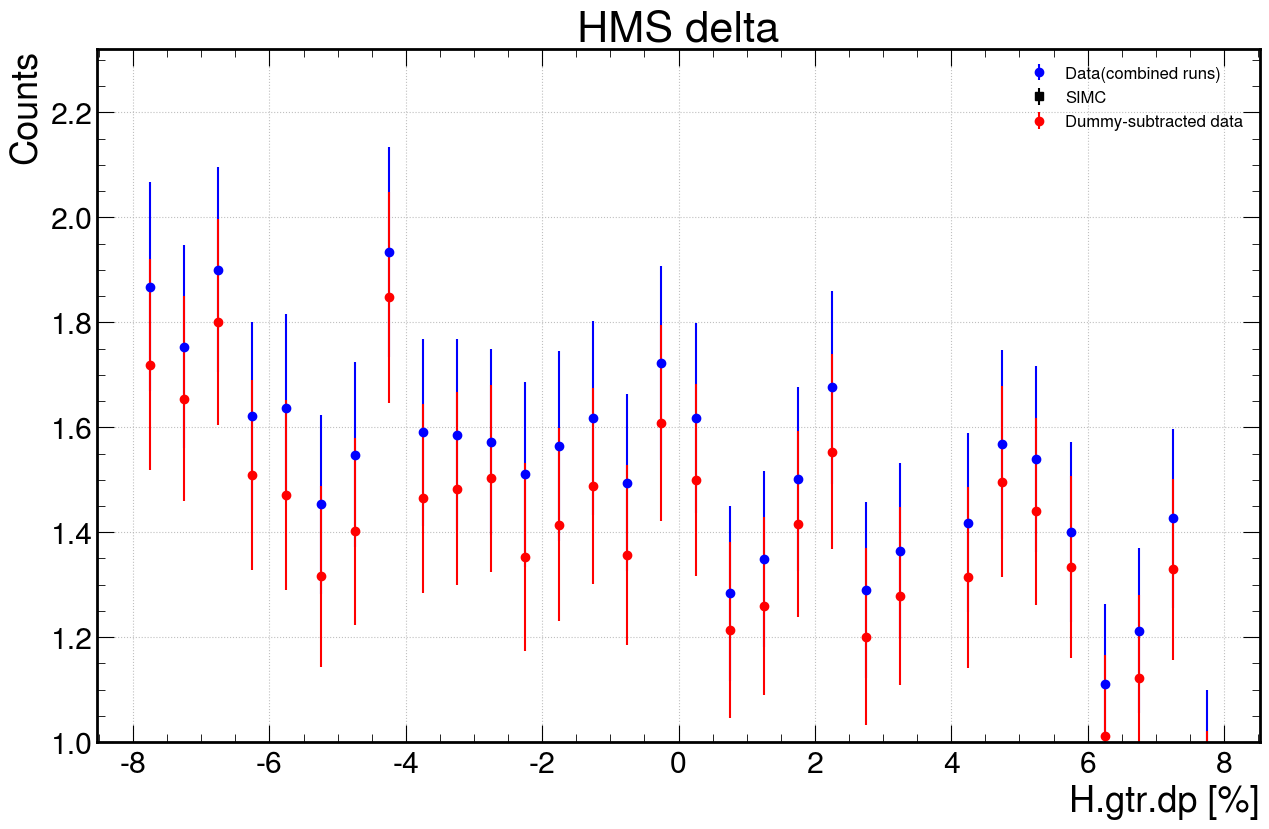

In [120]:
import mplhep as hep
plt.style.use(hep.style.ROOT)

bin_num = 32
var_to_plot = ["H.gtr.dp","hsdelta"]
bin_range = (-8, 8)
Al_thick = 0.184  # mm
dummy_thick = 0.60605  # mm
R = Al_thick / dummy_thick
normfac = 0.838913E+11 
histo = make_histograms(bin_num, bin_range)

diff_percent = 100 * (histo["counts_sub"] - histo["counts_sim"]) / histo["counts_sim"]
mean_diff = np.mean(np.abs(diff_percent))
print(f"Average relative difference: {mean_diff:.2f}%")

plt.figure(figsize=(15, 9))

# plt.step(histo["centers_data"], histo["counts_data"], where='mid', label='Data', color='blue')
# plt.step(histo["centers_sim"], histo["counts_sim"], where='mid', label='SIMC', color='black')
# plt.fill_between(histo["centers_sub"], 0, histo["counts_sub"], step='mid', alpha=0.3, color='red', label='Dummy-subtracted')
plt.errorbar(histo["centers_data"], histo["counts_data"], yerr=histo["errors_data"], fmt='o', color='blue', label='Data(combined runs)')
plt.errorbar(histo["centers_sim"], histo["counts_sim"], yerr=histo["errors_sim"], fmt='s', color='black', label='SIMC')
plt.errorbar(histo["centers_sub"], histo["counts_sub"], yerr=histo["errors_sub"], fmt='o', color='red', label="Dummy-subtracted data")
plt.xlabel("H.gtr.dp [%]")
plt.ylabel("Counts")
plt.ylim(1, max(histo["counts_data"])*1.2)
plt.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
plt.title("HMS delta")
plt.legend(fontsize=12)
plt.grid(True)
plt.show()



# SHMS Delta

Average relative difference: 19.04%


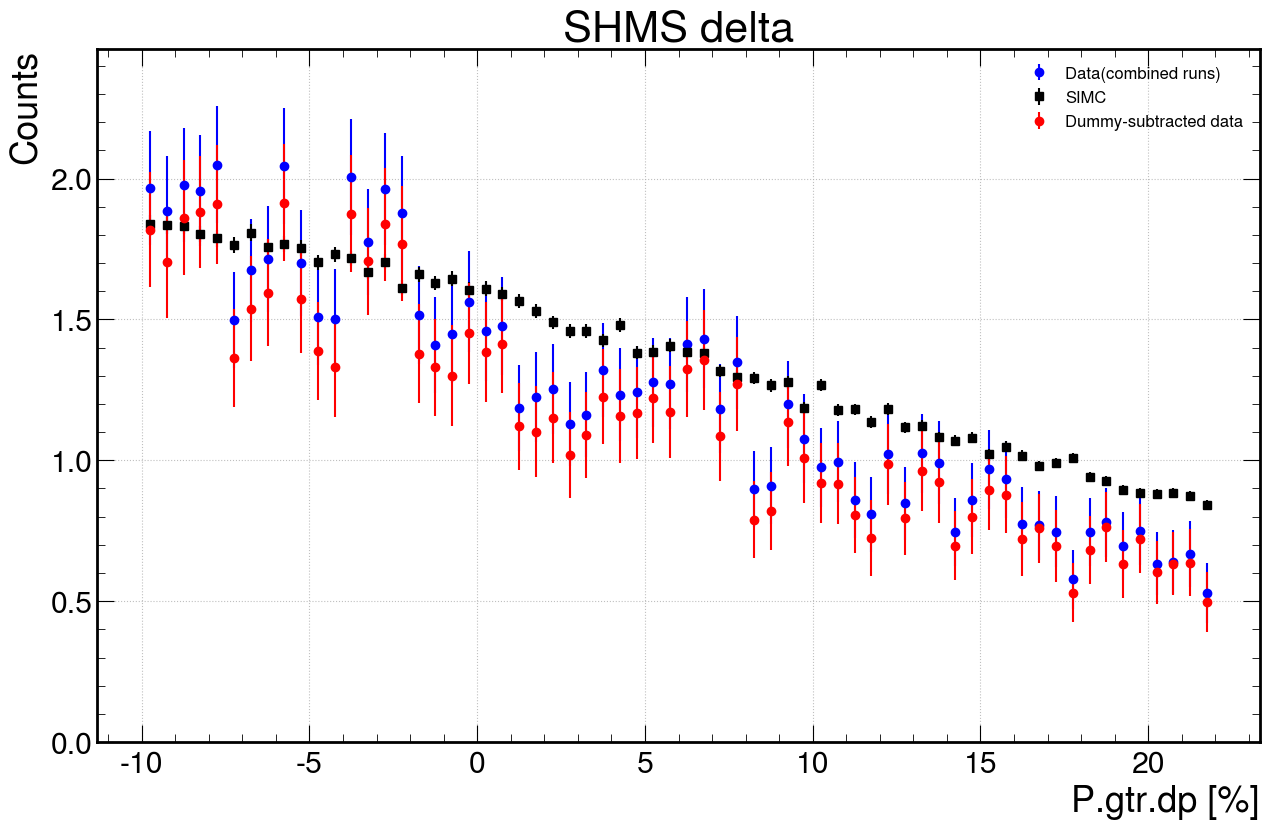

In [ ]:
bin_num = 64
var_to_plot = ["P.gtr.dp","ssdelta"]
bin_range = (-10, 22)

histo = make_histograms(bin_num, bin_range)

diff_percent = 100 * (histo["counts_sub"] - histo["counts_sim"]) / histo["counts_sim"]
mean_diff = np.mean(np.abs(diff_percent))
print(f"Average relative difference: {mean_diff:.2f}%")

plt.figure(figsize=(15, 9))

plt.errorbar(histo["centers_data"], histo["counts_data"], yerr=histo["errors_data"], fmt='o', color='blue', label='Data(combined runs)')
plt.errorbar(histo["centers_sim"], histo["counts_sim"], yerr=histo["errors_sim"], fmt='s', color='black', label='SIMC')
plt.errorbar(histo["centers_sub"], histo["counts_sub"], yerr=histo["errors_sub"], fmt='o', color='red', label="Dummy-subtracted data")
plt.xlabel("P.gtr.dp [%]")
plt.ylabel("Counts")
plt.ylim(0, max(histo["counts_data"])*1.2)
plt.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
plt.title("SHMS delta")
plt.legend(fontsize=12)
plt.grid(True)
plt.show()

# HMS ytar

Average relative difference: 64.34%


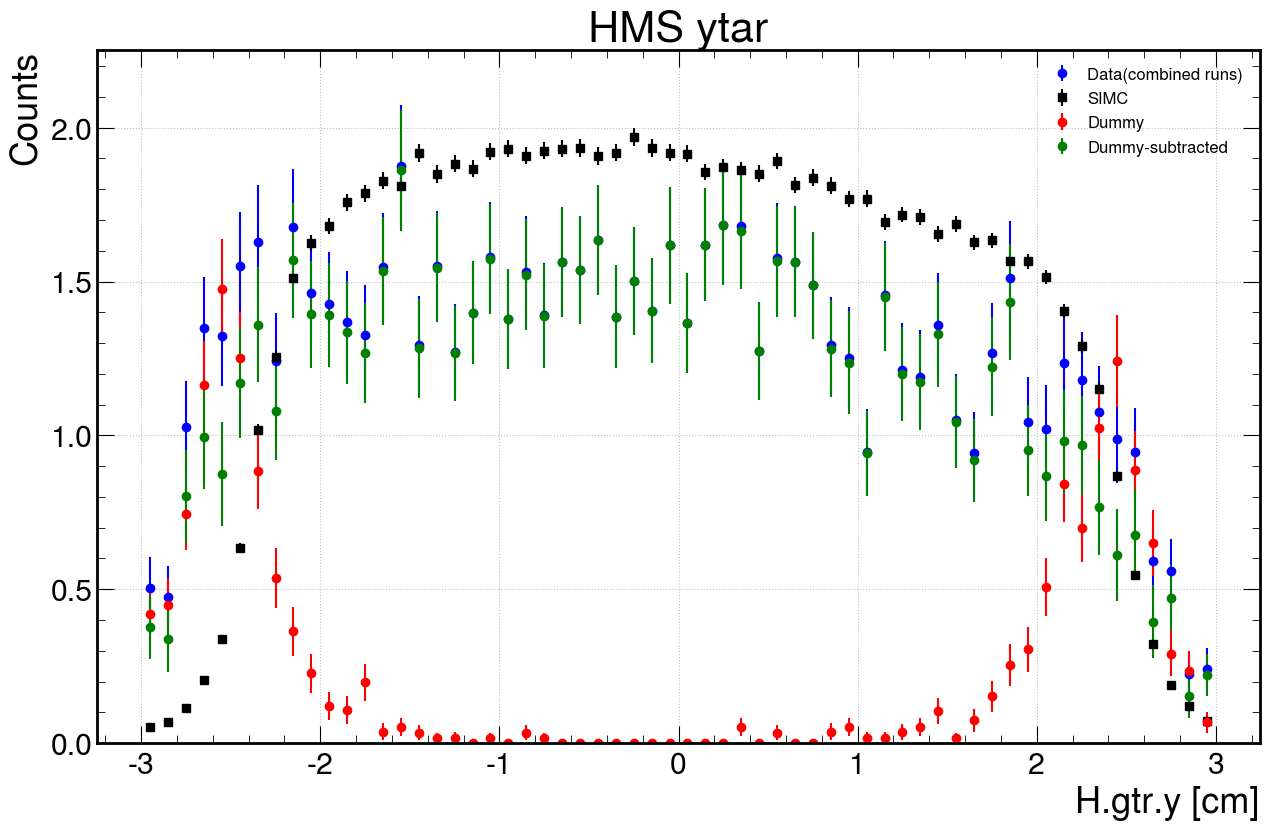

In [ ]:
bin_num = 60
var_to_plot = ["H.gtr.y","hsytar"]
bin_range = (-3, 3)

histo = make_histograms(bin_num, bin_range)

diff_percent = 100 * (histo["counts_sub"] - histo["counts_sim"]) / histo["counts_sim"]
mean_diff = np.mean(np.abs(diff_percent))
print(f"Average relative difference: {mean_diff:.2f}%")

plt.figure(figsize=(15, 9))

plt.errorbar(histo["centers_data"], histo["counts_data"], yerr=histo["errors_data"], fmt='o', color='blue', label='Data(combined runs)')
plt.errorbar(histo["centers_sim"], histo["counts_sim"], yerr=histo["errors_sim"], fmt='s', color='black', label='SIMC')
plt.errorbar(histo["centers_dummy"], histo["counts_dummy"], yerr=histo["errors_dummy"], fmt='o', color='red', label="Dummy")
plt.errorbar(histo["centers_sub"], histo["counts_sub"], yerr=histo["errors_sub"], fmt='o', color='green', label="Dummy-subtracted")
plt.xlabel("H.gtr.y [cm]")
plt.ylabel("Counts")
plt.ylim(0, max(histo["counts_data"])*1.2)
plt.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
plt.title("HMS ytar")
plt.legend(fontsize=12)
plt.grid(True)
plt.show()

# SHMS ytar

Average relative difference: 99.13%


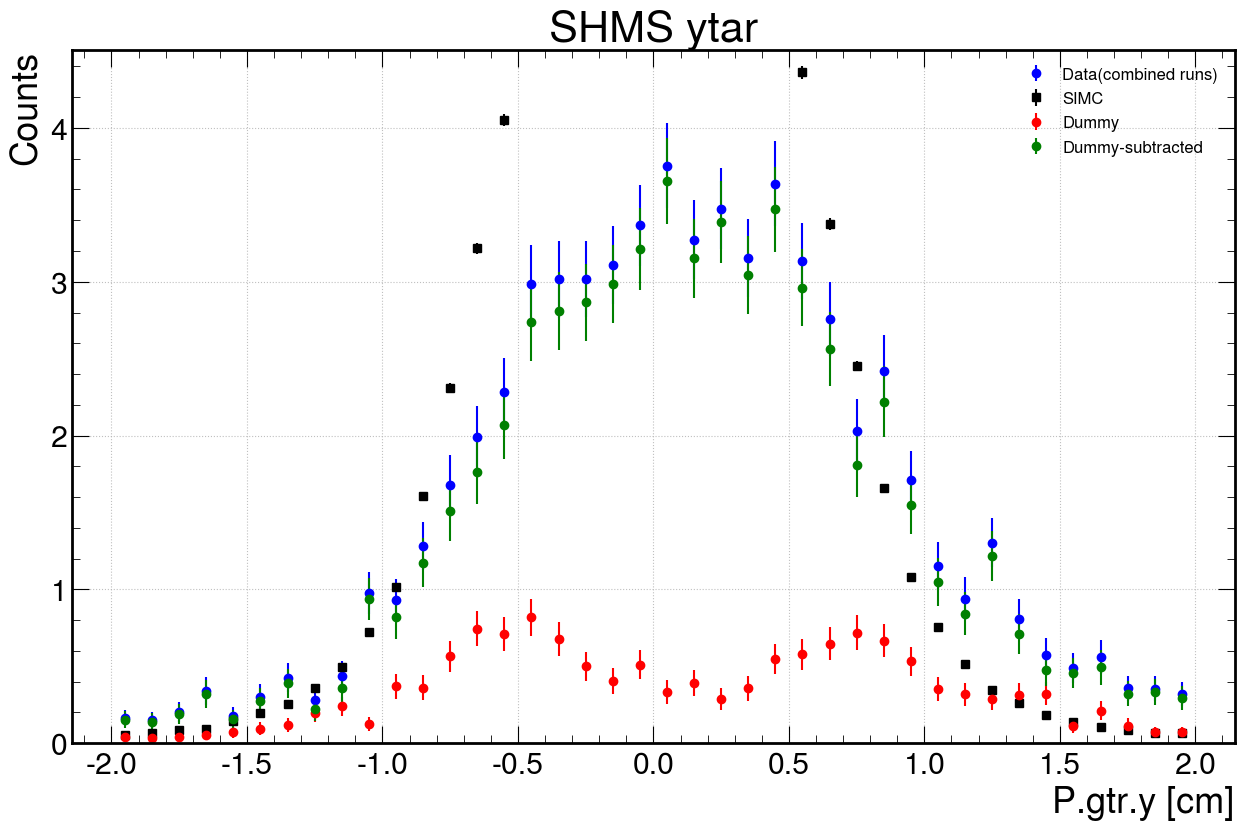

In [ ]:
bin_num = 40
var_to_plot = ["P.gtr.y","ssytar"]
bin_range = (-2, 2)

histo = make_histograms(bin_num, bin_range)

diff_percent = 100 * (histo["counts_sub"] - histo["counts_sim"]) / histo["counts_sim"]
mean_diff = np.mean(np.abs(diff_percent))
print(f"Average relative difference: {mean_diff:.2f}%")

plt.figure(figsize=(15, 9))

plt.errorbar(histo["centers_data"], histo["counts_data"], yerr=histo["errors_data"], fmt='o', color='blue', label='Data(combined runs)')
plt.errorbar(histo["centers_sim"], histo["counts_sim"], yerr=histo["errors_sim"], fmt='s', color='black', label='SIMC')
plt.errorbar(histo["centers_dummy"], histo["counts_dummy"], yerr=histo["errors_dummy"], fmt='o', color='red', label="Dummy")
plt.errorbar(histo["centers_sub"], histo["counts_sub"], yerr=histo["errors_sub"], fmt='o', color='green', label="Dummy-subtracted")
plt.xlabel("P.gtr.y [cm]")
plt.ylabel("Counts")
plt.ylim(0, max(histo["counts_data"])*1.2)
plt.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
plt.title("SHMS ytar")
plt.legend(fontsize=12)
plt.grid(True)
plt.show()

# Bjorken-x

Average relative difference: 159.28%
μ = 0.2479 ± 0.0004


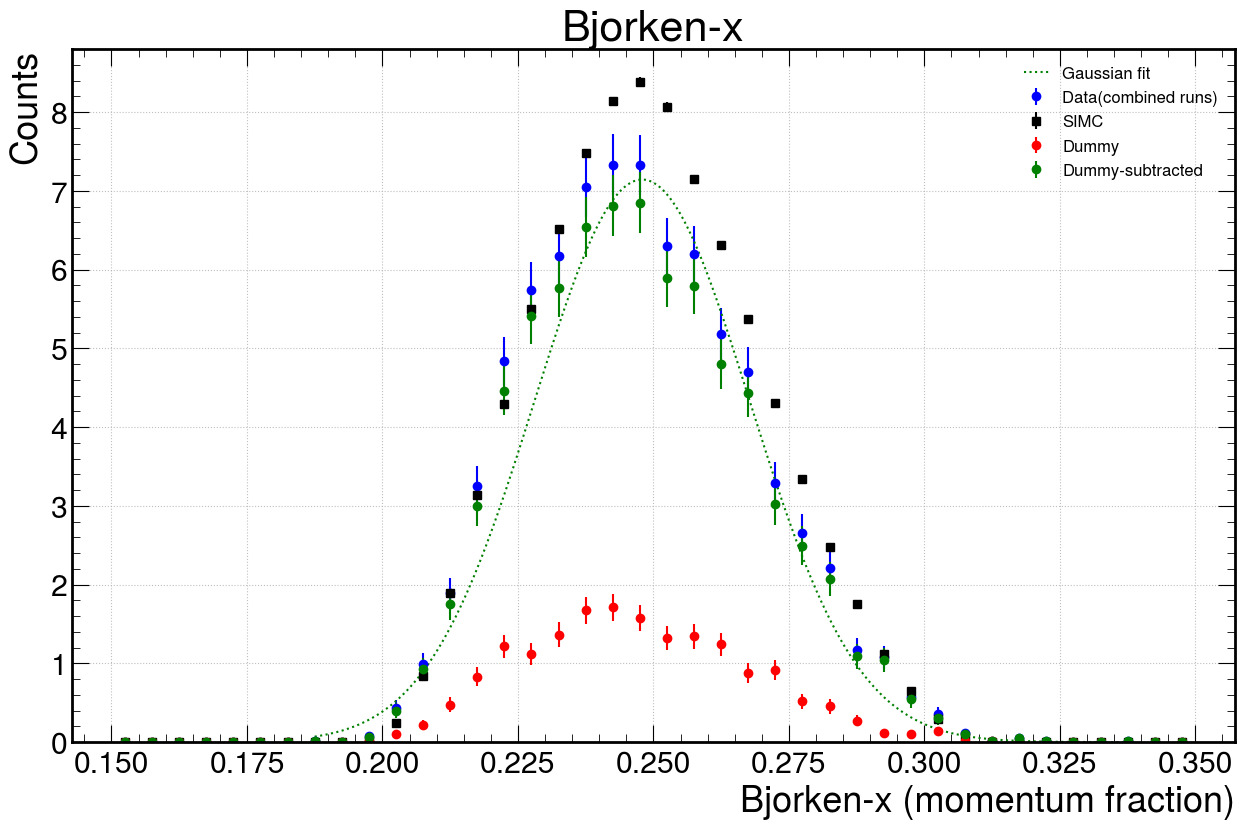

In [ ]:
from scipy.optimize import curve_fit

bin_num = 40
var_to_plot = ["H.kin.primary.x_bj","xbj"]
bin_range = (0.15, 0.35)

histo = make_histograms(bin_num, bin_range)

def gaussian(x, A, mu, sigma):
    return A * np.exp(-(x - mu)**2 / (2 * sigma**2))

mask = histo["counts_sub"] > 0
x_fit = histo["centers_sub"][mask]
y_fit = histo["counts_sub"][mask]
y_err = histo["errors_sub"][mask]

p0 = [np.max(y_fit), np.mean(x_fit), np.std(x_fit)]

popt, pcov = curve_fit(gaussian, x_fit, y_fit, p0=p0, sigma=y_err, absolute_sigma=True)

A_fit, mu_fit, sigma_fit = popt
A_err, mu_err, sigma_err = np.sqrt(np.diag(pcov))


mask = histo["counts_sim"]>0
diff_percent = 100 * (histo["counts_sub"][mask] - histo["counts_sim"][mask]) / histo["counts_sim"][mask]
mean_diff = np.mean(np.abs(diff_percent))
print(f"Average relative difference: {mean_diff:.2f}%")
print(f"μ = {mu_fit:.4f} ± {mu_err:.4f}")

plt.figure(figsize=(15, 9))

plt.errorbar(histo["centers_data"], histo["counts_data"], yerr=histo["errors_data"], fmt='o', color='blue', label='Data(combined runs)')
plt.errorbar(histo["centers_sim"], histo["counts_sim"], yerr=histo["errors_sim"], fmt='s', color='black', label='SIMC')
plt.errorbar(histo["centers_dummy"], histo["counts_dummy"], yerr=histo["errors_dummy"], fmt='o', color='red', label="Dummy")
plt.errorbar(histo["centers_sub"], histo["counts_sub"], yerr=histo["errors_sub"], fmt='o', color='green', label="Dummy-subtracted")
x_smooth = np.linspace(np.min(x_fit), np.max(x_fit), 500)
plt.plot(x_smooth, gaussian(x_smooth, *popt), color='green', linestyle="dotted", label="Gaussian fit")
plt.xlabel("k (bin value)")
plt.xlabel("Bjorken-x (momentum fraction)")
plt.ylabel("Counts")
plt.ylim(0, max(histo["counts_data"])*1.2)
plt.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
plt.title("Bjorken-x")
plt.legend(fontsize=12)
plt.grid(True)
plt.show()

# Q^2

Average relative difference: 63.84%
μ = 3.2757 ± 0.0045


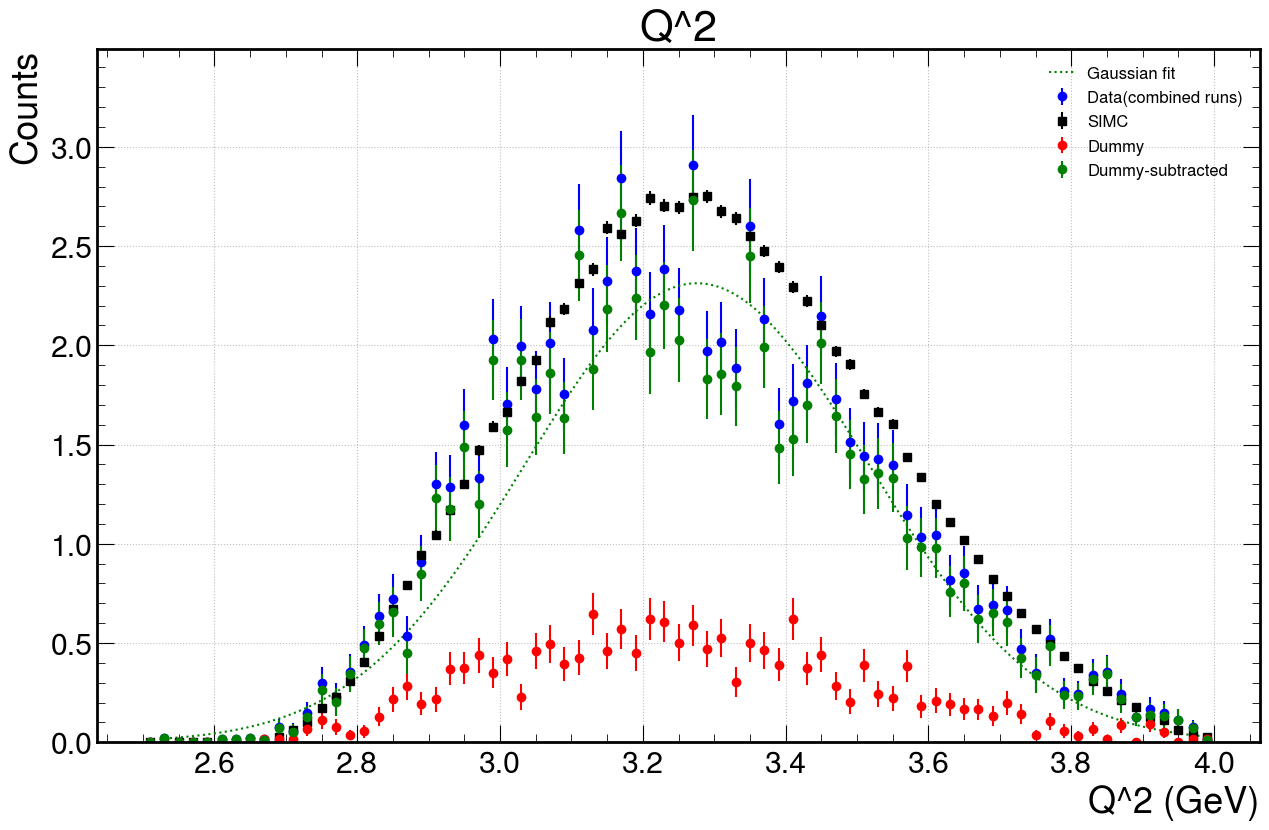

In [ ]:
bin_num = 75
var_to_plot = ["H.kin.primary.Q2", "Q2"]
bin_range = (2.5, 4)

histo = make_histograms(bin_num, bin_range)

def gaussian(x, A, mu, sigma):
    return A * np.exp(-(x - mu)**2 / (2 * sigma**2))

mask = histo["counts_sub"] > 0
x_fit = histo["centers_sub"][mask]
y_fit = histo["counts_sub"][mask]
y_err = histo["errors_sub"][mask]

p0 = [np.max(y_fit), np.mean(x_fit), np.std(x_fit)]

popt, pcov = curve_fit(gaussian, x_fit, y_fit, p0=p0, sigma=y_err, absolute_sigma=True)

A_fit, mu_fit, sigma_fit = popt
A_err, mu_err, sigma_err = np.sqrt(np.diag(pcov))


mask = histo["counts_sim"]>0
diff_percent = 100 * (histo["counts_sub"][mask] - histo["counts_sim"][mask]) / histo["counts_sim"][mask]
mean_diff = np.mean(np.abs(diff_percent))
print(f"Average relative difference: {mean_diff:.2f}%")
print(f"μ = {mu_fit:.4f} ± {mu_err:.4f}")
plt.figure(figsize=(15, 9))

plt.errorbar(histo["centers_data"], histo["counts_data"], yerr=histo["errors_data"], fmt='o', color='blue', label='Data(combined runs)')
plt.errorbar(histo["centers_sim"], histo["counts_sim"], yerr=histo["errors_sim"], fmt='s', color='black', label='SIMC')
plt.errorbar(histo["centers_dummy"], histo["counts_dummy"], yerr=histo["errors_dummy"], fmt='o', color='red', label="Dummy")
plt.errorbar(histo["centers_sub"], histo["counts_sub"], yerr=histo["errors_sub"], fmt='o', color='green', label="Dummy-subtracted")
x_smooth = np.linspace(np.min(x_fit), np.max(x_fit), 500)
plt.plot(x_smooth, gaussian(x_smooth, *popt), color='green', linestyle="dotted", label="Gaussian fit")
plt.xlabel("Q^2 (GeV)")
plt.ylabel("Counts")
plt.ylim(0, max(histo["counts_data"])*1.2)
plt.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
plt.title("Q^2")
plt.legend(fontsize=12)
plt.grid(True)
plt.show()